In [1]:
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import deap
import math
import matplotlib.colors as mcolors
import matplotlib
matplotlib.use('nbagg')
%matplotlib notebook

# Random graph generator, other usefull functions

Generative algorithm solving **matrix cover** problem. Using [DEAP](https://pypi.org/project/deap/) library (inspired by [official examples](https://github.com/DEAP))

## Generates random graph represented by matrix, not necessarily continuous

In [2]:
'''In short the method creates sparse symetric binary matrices with specified density.
    Matrices must be symmetric because It is used as adjescency matrix of unoriented graph
    and sparsity leaves us with more general graph.
    In case of high number of nodes lower density.
'''
def random_graph(size):
    def wrapper(x):
        return np.random.randint(0,2, size=x)
    mat = sparse.random(size, size, density=0.07, data_rvs=wrapper).toarray().astype(int)
    graph = np.matrix([np.bitwise_or(a,b) for a, b in zip(mat, mat.T)])
    return graph

## Checks if graph has isolated nodes

In [3]:
''' Basically checks whether all nodes have at least one edge. If this condition isn't fulfilled GA may get stuck
    such nodes and give worse results.
'''
def check(mat):
    a = mat[0]-mat[0]
    for x in mat:
        a += x
    for x in np.array(a)[0]:
        if x == 0:
            return False
    return True

## Returns list of indexes of binary array where are one-s

In [4]:
''' Returns list of indexes which were 1 in binary matrix
'''
def zip_vector(vect):
    zipped = []
    for x in range(len(vect)):
        if vect[x]:
            zipped.append(x)
    return zipped

## Colour representation of nodes and edges

In [5]:
''' Helper method to generate kwargs for matplotlib 
'''
def generate_graph_kwargs(G, selected=None):
    if not selected:
        return  {"width":0.8, "with_labels":True}
    direct = 'g'
    adjective = 'y'
    
    zpv = zip_vector(selected)

    edge_color = []
    adjective_nodes = []
    node_color = []

    for edge in G.edges():
        if edge[0] is edge[1]:
            if edge[0] in zpv:
                edge_color.append(direct)
                continue
                
        if edge[0] in zpv:
            if not edge[1] in zpv:
                adjective_nodes.append(edge[1])
            edge_color.append(direct)
            continue
             
        elif edge[1] in zpv:
            adjective_nodes.append(edge[0])
            edge_color.append(direct)
            continue
            
        else:
            edge_color.append('#BEBEBE')
            
    node_color = ["#BEBEBE" for x in range(len(G.nodes()))]
    for x in zpv:
        node_color[x] = direct
    for x in adjective_nodes:
        node_color[x] = adjective
    return {"width":0.6,"node_size":50, "node_color":node_color, "edge_color":edge_color, "with_labels":False}

## Fitness function evaluation + wrapper

In [6]:
''' Fitness function calculating percentage coverage of graph and number of nodes used for it
'''
def eval_fitness(G, _sel):
    s_nodes = zip_vector(_sel)
    nodes = set(s_nodes)
    for node in s_nodes:        
        edges = G.edges(node)
        for edge in edges:
            nodes.add(edge[1])
            
    cnt = len(G.nodes())
    return [(1+len(nodes))/(1+cnt), len(s_nodes)]

In [7]:
''' wrapper for DEAP module, since fitness function is called with only individual as parameter
'''
def fitness_wrap(G):
    def caller(unit):
        return eval_fitness(G, unit)
    return caller

# Genetic Algorithm

In [8]:
size = 100 # represents number of nodes in graph

In [9]:
graph = random_graph(size)

while not check(graph): 
    graph = random_graph(size)
    
print("OK" if check(graph) else "FAIL")
G = nx.from_numpy_matrix(graph)

OK


<IPython.core.display.Javascript object>


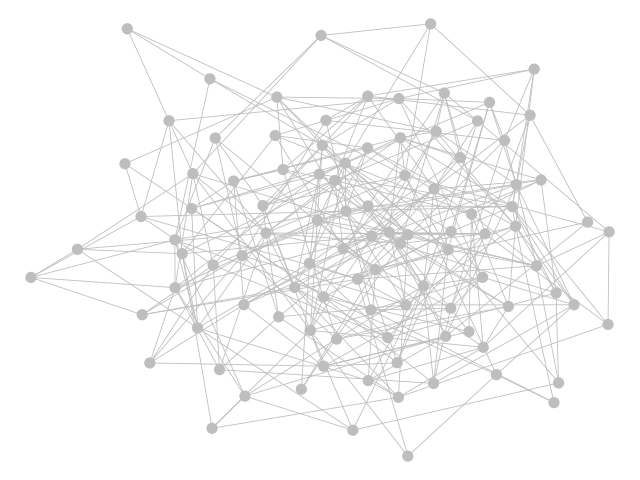

In [10]:
plt.figure(1)
nx.draw(G, **generate_graph_kwargs(G, [0 for x in range(size)]))
plt.title("Generated graph")
plt.show()

In [11]:
from deap import algorithms, base, creator, tools

In [12]:
funct = fitness_wrap(G)

In [13]:
creator.create("FitnessFunc", base.Fitness, weights=(1.0,-1.0))
creator.create("Individual", list, fitness=creator.FitnessFunc)

In [14]:
# setup of toolbox
tb = base.Toolbox()
tb.register("bit", np.random.randint, 0, 2)
tb.register("individual", tools.initRepeat, creator.Individual, tb.bit, n=size)
tb.register("population", tools.initRepeat, list, tb.individual)
tb.register("evaluate", funct)
tb.register("mate", tools.cxUniform, indpb=0.2)
tb.register("mutate",  tools.mutFlipBit, indpb=0.07)
tb.register("select", tools.selRoulette)

In [15]:
MU, LAMBDA = 15, 100

In [16]:
pop = tb.population(n=MU)
hof = tools.ParetoFront() # hall of fame
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

res = algorithms.eaMuPlusLambda(pop, tb, mu=MU, lambda_=LAMBDA,cxpb=0.5, mutpb=0.2, ngen=50,stats=stats, halloffame=hof)

gen	nevals	avg                      	min                      	max      
0  	15    	[ 0.98745875 47.26666667]	[ 0.97029703 38.        ]	[ 1. 53.]
1  	68    	[ 0.98811881 46.33333333]	[ 0.97029703 38.        ]	[ 1. 56.]
2  	69    	[ 0.98679868 49.06666667]	[ 0.97029703 38.        ]	[ 1. 56.]
3  	69    	[ 0.98943894 49.73333333]	[ 0.97029703 41.        ]	[ 1. 64.]
4  	66    	[ 0.99009901 51.13333333]	[ 0.97029703 45.        ]	[ 1. 56.]
5  	71    	[ 0.98943894 50.46666667]	[ 0.97029703 45.        ]	[ 1. 56.]
6  	69    	[ 0.99009901 50.46666667]	[ 0.97029703 44.        ]	[ 1. 56.]
7  	73    	[ 0.98613861 50.4       ]	[ 0.97029703 45.        ]	[ 1. 56.]
8  	77    	[ 0.98547855 50.66666667]	[ 0.97029703 44.        ]	[ 1. 57.]
9  	62    	[ 0.98547855 51.13333333]	[ 0.97029703 45.        ]	[ 1. 57.]
10 	71    	[ 0.98679868 51.        ]	[ 0.96039604 46.        ]	[ 1. 57.]
11 	72    	[ 0.99141914 51.6       ]	[ 0.98019802 48.        ]	[ 1. 57.]
12 	72    	[ 0.99207921 51.2       ]	[ 0.98019802 4

In [17]:
# visual prep
stats=[funct(x) for x in hof]
nsize,height = map(list, zip(*stats))
idx = [x for x in range(len(height))]
clist = [(0, "red"), (0.4, "red"), (0.5, "orange"),(0.9, "orange"),(1, "green")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

<IPython.core.display.Javascript object>


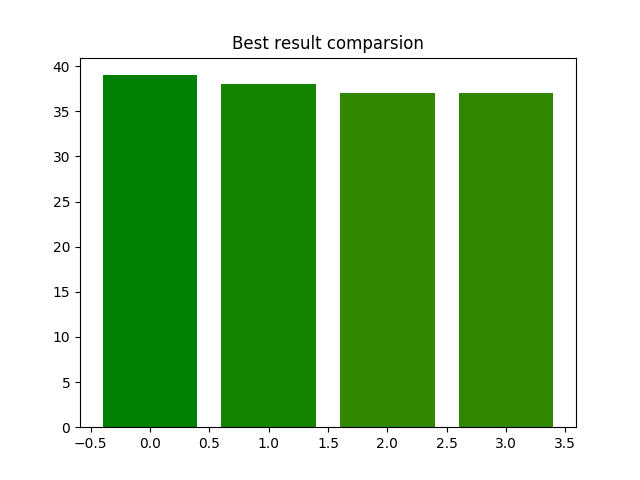

In [18]:
plt.figure(111)
plt.bar(x=idx, height=height, color=rvb(nsize))
plt.title("Best result comparsion")
plt.show()

<IPython.core.display.Javascript object>


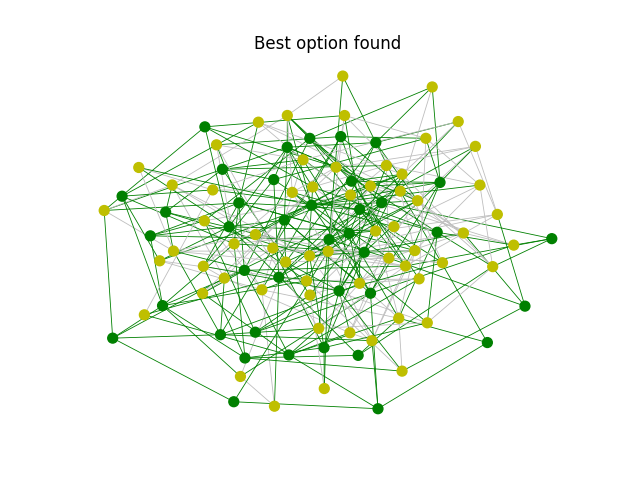

In [19]:
plt.figure(88)
plt.clf()
plt.title("Best option found")
nx.draw(G, **generate_graph_kwargs(G, hof[0]))
plt.show();

In [20]:
print("Ones in vector:", len(zip_vector(hof[0])))
print("Indexes of ones:", zip_vector(hof[0]))

Ones in vector: 39
Indexes of ones: [1, 3, 4, 5, 8, 9, 10, 13, 14, 16, 18, 20, 21, 24, 26, 27, 28, 30, 36, 38, 41, 43, 44, 48, 49, 53, 55, 58, 62, 70, 72, 73, 74, 75, 82, 93, 94, 96, 97]
